# Exercises - Week 4 - Model Flexibility & Bias Variance Decomposition
#### Simon Lee, BIO-322, Machine Learning for Bioengineers, Winter 2022

## Conceptual
#### Exercise 1
For each example below, indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.
+ The sample size n is extremely large, and the number of predictors $p$ is small.
+ The number of predictors $p$ is extremely large, and the number of observations $n$ is small.
+ The relationship between the predictors and response is highly non-linear.
+ The variance of the error terms, i.e. $\sigma^2 = Var(\epsilon)$, is extremely high.

#### Solution

* A flexible method would be better. A flexible method will fit the data closer, and with $n\\gg p` the risk of overfitting is small.
* A flexible method would be worse. Because a flexible method fits the data closer, it is more likely to overfit when there is a small number of observations compared to the number of predictors.
* A flexible method is better. With more degrees of freedom, a flexible method is more capable of producing highly non-linear behavior than an inflexible method.
* A flexible method is worse. If observations are very noisy, a flexible method is more likely to fit to the noise and thereby overfit.

#### Exercise 2
The table below provides a training data set containing six observations, three predictors, and one qualitative response variable. Suppose we wish to use this data set to make a prediction for $Y$ when $X_1 = X_2 = X_3 = 0$ using K-nearest neighbors.
- Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.
- What is our prediction with K = 1? Why?
- What is our prediction with K = 3? Why?
- If the decision boundary at threshold 0.5 in this problem is highly non- linear, then would we expect the best value for K to be large or small? Why?

|Obs.|$X_1$|$X_2$|$X_3$|$Y$|
|:----|-------|-------|-------|-----:|
|1 | 0 | 3 | 0 | Red|
|2 | 2 | 0 | 0 | Red|
|3 | 0 | 1 | 3 | Red|
|4 | 0 | 1 | 2 | Green|
|5 | -1| 0 | 1 | Green|
|6 | 1 | 1 | 1 | Red|

#### Solution

* $d_1 = 3, d_2 = 2, d_3 = \ \sqrt{10}, d_4 = \ \sqrt{5}, d_5 = \ \sqrt{2}, d_6 = \ \sqrt{3}$. We have $d_5 < d_6 < d_2 < d_4 < d_1 < d_3$.
* With $K = 1$ we would predict the same label as closest training data point, i.e. $ Y_5 = $ Green.
* With $K = 3$ we would predict Red (for any decision threshold below 2/3) because two of the three nearest neigbors have label Red.
* A highly non-linear decision boundary requires a flexible method. K-nearest neigbors is more flexible for small $K$s than for large $K$s. Therefore we would need a rather small $K$.

#### Exercise 3
Try without looking at the figure above:
- Provide a sketch of typical (squared) bias, variance, training error, test error, and Bayes (or irreducible) error curves, on a single plot, as we go from less flexible statistical learning methods towards more flexible approaches. The x-axis should represent the amount of flexibility in the method, and the y-axis should represent the values for each curve. There should be five curves. Make sure to label each one.
- Explain why each of the five curves has its particular shape.

#### Solution


The training error declines monotonically as flexibility increases because with more flexibility the model ($\ \hat{f}$) fits the observed data more closely. The test error intially declines as flexibility increases but at some point it levels off and then starts to increase again (U-shape). When the model $\ \hat{f}$ yields a small training error but a large test error we say we are overfitting the data (i.e., our model fits too exactly to patterns in the training data that are caused by noise rather than by the true underlying function $f$). The squared bias decreases monotonically and the variance increases monotonically; as a general rule, as we use more flexible methods, the variance will increase and the bias will decrease. The irreducible error does not depend on our method so it is a horizontal line. It always lies below the test error curve because the test error will always be greater than $Var(\ \varepsilon)$.

"Bias" refers to the systematic error that is introduced by approximating a complex model with a much simpler model. If we use a very simple model (i.e., an inflexible one, such as linear regression) it is essentially impossible to closely reproduce a true non-linear function $f$, and this increases the test error. "Variance" refers to the amount by wich our model $\ \hat{f}$ would fluctuate if we estimated it using different training data sets. When our method is very flexible, variance is typically high, which means that changing any training data point may cause $\ \hat{f}$ to change considerably. This will result in higher test error.

#### Exercise 4
Suppose that we take a data set with mutually distinct inputs $x_i\neq x_j$ for $i\neq j$, divide it into equally-sized training and test sets, and then try out two different classification procedures. First we use logistic regression and get an error rate of 20% on the training data and 30% on the test data. Next we use 1-nearest neighbors (i.e. $K = 1$) and get an average error rate (averaged over both test and training data sets) of 18%. Based on these results, which method should we prefer to use for classification of new observations? Why?


#### Solution

We should prefer logistic regression to use for classification of new observations.
1-nearest neighbors classification has 0 error on the training set. Therefore an average error rate on equally sized training and test sets means the test error of 1-nearest neighbors classification is 36%. Because logistic regression has a lower test error rate we should prefer it.

## Applied
#### Exercise 5
Apply K-nearest neighbors regression to the weather data set. Use as input all predictors except `:time` and `:LUZ_wind_peak`.
* Compute the training and the test loss for $K = 5, 10, 20, 50, 100$.
* Which value of the hyper-parameter $K$ should we prefer to make predictions on new data?
* Should we prefer K-nearest neighbors with optimal $K$ or multiple linear regression to make predictions on new data? *Hint*: Remember that we found a training error (RMSE) of approximately 8.1 and a test error of 8.9.


In [7]:
begin
    using Pkg
    Pkg.activate(joinpath(Pkg.devdir(), "MLCourse"))
    using CSV, DataFrames, MLJ, NearestNeighborModels, MLCourse
end

  Activating project at `~/.julia/dev/MLCourse`


In [8]:
begin
	weather_train = CSV.read(joinpath(@__DIR__, "data", "weather2015-2018.csv"),
		                     DataFrame)
    weather_test = CSV.read(joinpath(@__DIR__, "data", "weather2019-2020.csv"),
		                    DataFrame)
end;

In [9]:
begin
    function preprocess(data)
		(X = float.(select(data[1:end-5, :], Not([:LUZ_wind_peak, :time]))),
         y = data.LUZ_wind_peak[6:end])
    end
    function fit_and_evalute(K, train, test)
        X, y = preprocess(train)
        Xtest, ytest = preprocess(test)
        m = machine(KNNRegressor(K = K), X, y) |> fit!
        (training_error = rmse(predict(m, X), y),
         test_error = rmse(predict(m, Xtest), ytest))
    end
end

fit_and_evalute (generic function with 1 method)

In [10]:
fit_and_evalute(5, weather_train, weather_test)

┌ Info: Training machine(KNNRegressor(K = 5, …), …).
└ @ MLJBase /Users/simonlee/.julia/packages/MLJBase/kihuj/src/machines.jl:496


(training_error = 6.881318687330984,
 test_error = 9.948272186916055,)

In [11]:
fit_and_evalute(10, weather_train, weather_test)

┌ Info: Training machine(KNNRegressor(K = 10, …), …).
└ @ MLJBase /Users/simonlee/.julia/packages/MLJBase/kihuj/src/machines.jl:496


(training_error = 7.580827899118955,
 test_error = 9.625799175497562,)

In [12]:
fit_and_evalute(20, weather_train, weather_test)

┌ Info: Training machine(KNNRegressor(K = 20, …), …).
└ @ MLJBase /Users/simonlee/.julia/packages/MLJBase/kihuj/src/machines.jl:496


(training_error = 8.003233139572567,
 test_error = 9.534794906764708,)

In [13]:
fit_and_evalute(50, weather_train, weather_test)

┌ Info: Training machine(KNNRegressor(K = 50, …), …).
└ @ MLJBase /Users/simonlee/.julia/packages/MLJBase/kihuj/src/machines.jl:496


(training_error = 8.350455705423498,
 test_error = 9.585000368112027,)

In [14]:
fit_and_evalute(100, weather_train, weather_test)

┌ Info: Training machine(KNNRegressor(K = 100, …), …).
└ @ MLJBase /Users/simonlee/.julia/packages/MLJBase/kihuj/src/machines.jl:496


(training_error = 8.575305476376224,
 test_error = 9.675105920499755,)

$K = 20$ leads to the lowest test error among all tested $K$s and should therefore be preferred for making predictions on unseen data. However, the test error for $K = 20$ is approximately $9.5$ which is larger than the test error of multiple linear regression (approximately $8.9$). Therefore multiple linear regression is preferrable.

#### Exercise 6
In this exercise we review the error-decomposition and the bias-variance decomposition.
* Write a data generator where the mean of the output depends through the non-linear function $f(x) = x^2 * \sin(x) + 4 * \tanh(10x)$ on the input and normally distributed noise $\epsilon$ with mean 0 and standard deviation 1.5.
    * Take the linear function $\hat f(x) = 2x$ and estimate its reducible error at input point $x = 0$ and at input point $x = 2$ in two ways:
        * Using directly $f$.
        * Using $10^5$ samples from the data generator. *Hint:* Use the samples to estimate the irreducible error and then use the error decomposition formula to compute the reducible error.
    * Generate $10^4$ training sets of 100 data points with input $x$ normally distributed with standard deviation 2 and mean 0 and estimate the bias of linear regression at $x = 4$  in two ways:
        * Using directly $f$.
        * Using $10^4$ samples from the data generator. *Hint:* Use again the samples to estimate the irreducible error and use the bias-variance decomposition formula to compute the bias.

In [15]:
begin
    f(x) = x^2 * sin(x) + 4*tanh(10x)
    data_generator(x) = DataFrame(x = x, y = f.(x) .+ 1.5*randn(length(x)))
end

data_generator (generic function with 1 method)

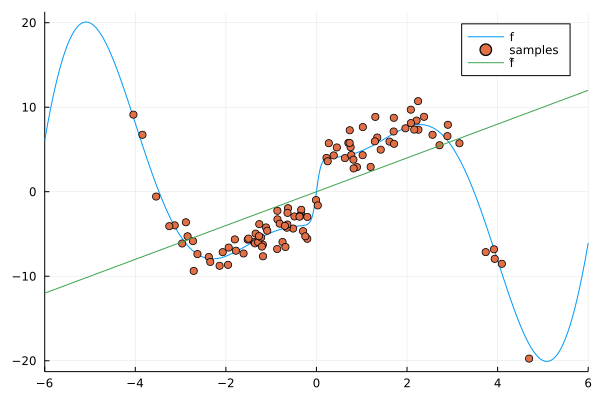

In [28]:
begin
    using Plots
    plot(f, xlims = (-6, 6), label = "f")
    scatter!((x -> (x.x, x.y))(data_generator(2*randn(100)))..., label = "samples")
    plot!(x -> 2x, label = "f̂")
end

#### Error Decomposition

In [16]:
f̂(x) = 2x

f̂ (generic function with 1 method)

In [17]:
(f(0) - f̂(0))^2

0.0

In [18]:
using Statistics # for var

In [19]:
let samples = data_generator(fill(0, 10^5))
	sigma2 = var(samples.y)
	mean((samples.y .- f̂(0)).^2) .- sigma2
end

-2.241865382668351e-5

In [20]:
(f(2) - f̂(2))^2

13.229148966908896

In [21]:
let samples = data_generator(fill(2, 10^5))
	sigma2 = var(samples.y)
	mean((samples.y .- f̂(2)).^2) .- sigma2
end

13.23472335852524

#### Bias Variance Decomposition

In [22]:
using MLJLinearModels # for LinearRegressor

In [23]:
function fit_and_predict()
	data = data_generator(2*randn(100))
	m = fit!(machine(LinearRegressor(), select(data, :x), data.y), verbosity = 0)
	predict(m, (x = [4],))[1]
end

fit_and_predict (generic function with 1 method)

In [24]:
predictions = [fit_and_predict() for _ in 1:10^4]

10000-element Vector{Float64}:
  3.205334960840191
  0.44604405922995505
  4.17862061465963
  5.654647349530754
 11.071462496220018
  5.287825989551823
 -0.9182716837064155
  2.5192584285568183
  0.8199279014921791
  4.088793949885932
  4.191230699785169
  6.097039509029098
  3.362808613612894
  ⋮
  5.887941443978492
  1.0284563716508748
  7.603044313113509
  3.0503858983083254
  7.120003252906576
  5.060152302710547
 10.085166449270574
  2.7283469736858743
  8.080834417722013
  3.99118322612397
  1.2905561149763718
  5.372320696153388

In [25]:
#Squared bias at x=4 the first way:
(f(4) - mean(predictions))^2

157.24857452605505

In [26]:
#and squared bias at x=4 the second way:
var(predictions)

5.8978158260524385

In [27]:
let samples = data_generator(fill(4, 10^4))
	sigma2 = var(samples.y)
	mean((samples.y .- predictions).^2) - var(predictions) - sigma2
end

158.26133637469687